In [157]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [39]:
import os
import glob
import copy
import pickle

from BSA3_pack import *

from struct import unpack
from scipy import signal
from tqdm import tqdm_notebook
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import Angle
from itertools import permutations


import numpy as np
import matplotlib.pyplot as plt

In [177]:
%%time
big_filename = './data_pntht/1133+16/010618_21_N2_00.pnthr'
filename = './data_pnt/1133+16/060618_21_N2_00.pnt'
# filename = './data_pnt/1237+25/040518_00_N1_00.pnt'
header, data = read_pnt(filename)

Wall time: 504 ms


In [178]:
print('npoints = ', len(data), '\n',
      'modules = ', len(data[0]), '\n',
      'rays = ', len(data[0][0]), '\n',
      'bands = ', len(data[0][0][0]))

npoints =  36017 
 modules =  6 
 rays =  8 
 bands =  7


In [179]:
obs_points = 5*u.min/(float(header['tresolution'][0])*u.millisecond).to(u.min)
obs_points = int(round(obs_points.value, 0))
print(obs_points)

3002


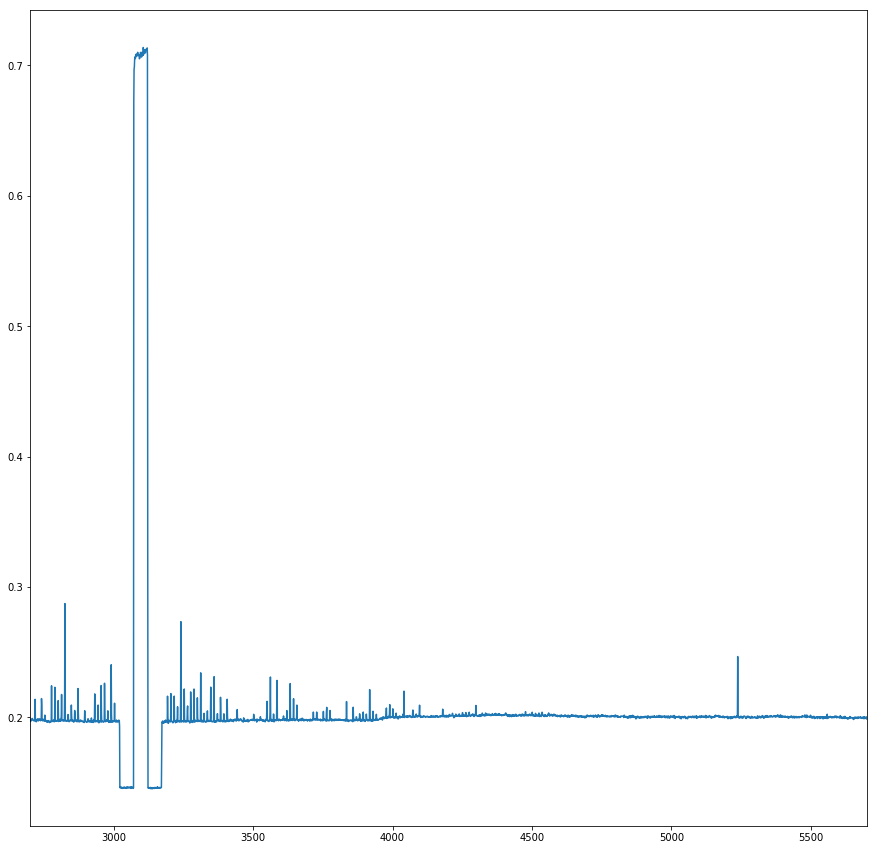

Wall time: 389 ms


In [180]:
%%time
module = 2
ray_1 = 3
#ray_2 = 8
chanel = 7
start_p = 2700
stop_p = start_p + obs_points

fig, ax = plt.subplots(figsize=(15, 15))

ax.plot([j[module-1][ray_1-1][chanel-1] for j in data])
#ax.plot([j[module-1][ray_2-1][chanel-1] for j in data])
plt.xlim(start_p, stop_p)
plt.show()

In [164]:
puls_data = [j[module-1][ray_1-1][chanel-1] for j in data[start_p:stop_p]]

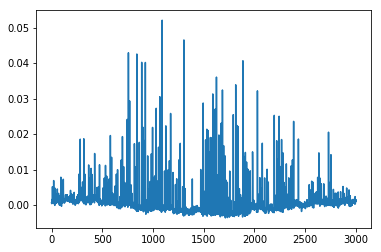

In [165]:
sig = puls_data - np.median(puls_data)
plt.plot(sig)
plt.show()

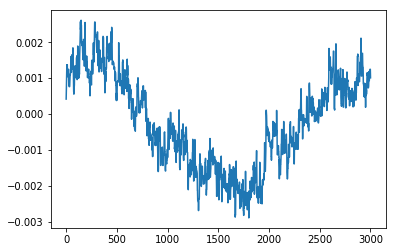

In [166]:
res_filter = signal.medfilt(sig, kernel_size=7)
plt.plot(res_filter)
plt.show()

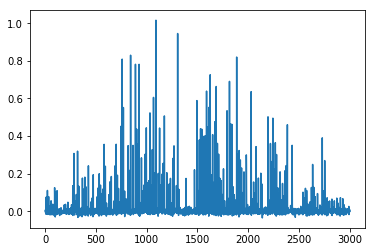

In [167]:
filtred_sig = (sig - res_filter)/max(sig)
plt.plot(filtred_sig)
plt.show()

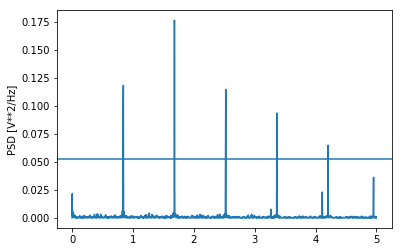

In [168]:
fs = 10 # понять физический смысл этого числа
f, Pxx_den = signal.periodogram(filtred_sig, fs)
plt.plot(f, Pxx_den)
plt.ylabel('PSD [V**2/Hz]')
plt.axhline(0.3*max(Pxx_den))
#plt.ylim(0, 0.00003)
#plt.xlim(0.2, 5)
plt.show()

In [169]:
_, points = np.where([Pxx_den > 0.3*max(Pxx_den)])

In [170]:
for i in points:
    print(f[i], f[i]/f[points[0]], (f[i])/(f[i]/f[points[0]]))

0.8394403730846103 1.0 0.8394403730846103
0.8427714856762158 1.003968253968254 0.8394403730846103
1.6822118587608261 2.003968253968254 0.8394403730846103
2.5216522318454366 3.0039682539682544 0.8394403730846102
2.524983344437042 3.0079365079365084 0.8394403730846102
3.3644237175216523 4.007936507936508 0.8394403730846103
4.207195203197868 5.011904761904762 0.8394403730846103


In [171]:
# Функция для создания последовательности временных значений для оси OX
def get_time(time_start, resolution, point):
    
    time = time_start +  point*float(resolution)*u.millisecond
    return time

In [172]:
time_start, time_end = get_time_begin_and_end(header)

In [173]:
start_point = get_time(time_start, header['tresolution'][0], start_p)

In [174]:
end_point = get_time(time_start, header['tresolution'][0], stop_p)

In [175]:
to_log = (start_point, end_point, filtred_sig,)

In [176]:
with open(os.path.basename(filename)[:-4] + '_part_pulse.log', 'wb') as file:
    pickle.dump(to_log, file)